In [1]:
import pandas as pd
import numpy as np
import torch
import pytorch_lightning as pl
from pathlib import Path
import sys
import time
from scipy.stats import wasserstein_distance
from sklearn.metrics import mean_squared_error
from tqdm import tqdm
import warnings
warnings.filterwarnings('ignore')

sys.path.insert(0, str(Path.cwd()))
from src.methods.DMF import DMFImputer
from src.methods.DCAE import DCAEImputer
from src.datasets import CSVDataset


def set_seed(seed=114514):
    np.random.seed(seed)
    torch.manual_seed(seed)
    if torch.cuda.is_available():
        torch.cuda.manual_seed_all(seed)
    pl.seed_everything(seed)

set_seed(114514)


Seed set to 114514


In [15]:
def load_data(data_path, missing_threshold=0.9):
    print(f"Loading data from: {data_path}")
    df_original = pd.read_csv(data_path)
    data_original = df_original.iloc[:, 1:].values.astype('float32')
    original_missing_mask = (data_original <= 0) | np.isnan(data_original)

    feature_missing_rate = original_missing_mask.mean(axis=0)
    valid_features = feature_missing_rate < missing_threshold
    n_removed = (~valid_features).sum()

    data_filtered = data_original[:, valid_features]
    missing_mask_filtered = original_missing_mask[:, valid_features]

    feature_columns = df_original.columns[1:][valid_features] 
    df_filtered = pd.concat([df_original.iloc[:, [0]], 
                            pd.DataFrame(data_filtered, columns=feature_columns)], axis=1)

    temp_path = data_path.replace('.csv', '_filtered.csv')
    df_filtered.to_csv(temp_path, index=False)
    dataset = CSVDataset(temp_path)
    
    print(f"Filtered data shape: {data_filtered.shape}")
    print(f"Filtered missing rate: {missing_mask_filtered.sum() / missing_mask_filtered.size:.2%}")

    return dataset, df_filtered, data_filtered, missing_mask_filtered

data_path = "./data/Alzheimer.csv"
dataset, df_original, data_original, original_missing_mask = load_data(data_path, missing_threshold=0.9)

Loading data from: ./data/Alzheimer.csv
Filtered data shape: (210, 1494)
Filtered missing rate: 18.88%


In [16]:
def create_shuffled_datasets(dataset, data_original, original_mask, n_shuffles=5, seed=42):
    np.random.seed(seed)
    shuffled_datasets = []
    
    print(f"Creating shuffled datasets with shape: {data_original.shape}")
    
    for i in range(n_shuffles):
        print(f"\nCreating shuffled dataset {i+1}/{n_shuffles}...")
        data_clean = np.nan_to_num(data_original, nan=0.0, posinf=0.0, neginf=0.0)        
        shuffled_data = data_clean.copy()
        shuffled_mask = original_mask.copy()

        assert shuffled_data.shape == shuffled_mask.shape, f"Shape mismatch: data {shuffled_data.shape} vs mask {shuffled_mask.shape}"
        
        for col_idx in range(data_clean.shape[1]):
            valid_indices = np.where(~original_mask[:, col_idx])[0]
            
            if len(valid_indices) > 0:
                valid_values = data_clean[valid_indices, col_idx].copy()
                shuffled_indices = valid_indices.copy()
                np.random.shuffle(shuffled_indices)
                shuffled_data[shuffled_indices, col_idx] = valid_values
        
        shuffled_data_tensor = torch.tensor(shuffled_data, dtype=torch.float32)
        shuffled_mask_tensor = torch.tensor(~shuffled_mask, dtype=torch.float32) 
        observed_mask = shuffled_mask_tensor == 1

        shuffle_mean = []
        shuffle_std = []
        data_normalized = torch.zeros_like(shuffled_data_tensor)

        for col_idx in range(shuffled_data_tensor.shape[1]):
            col_obs_mask = observed_mask[:, col_idx]
            if col_obs_mask.any():
                col_observed = shuffled_data_tensor[col_obs_mask, col_idx]
                col_mean = col_observed.mean()
                col_std = col_observed.std(unbiased=False)
                if torch.isnan(col_std) or torch.isinf(col_std) or col_std < 1e-6:
                    print(f"  Warning: Feature {col_idx} has std={col_std.item():.6f}, using default std=1.0")
                    col_std = torch.tensor(1.0, dtype=torch.float32, device=col_observed.device)
                data_normalized[col_obs_mask, col_idx] = (col_observed - col_mean) / col_std
                shuffle_mean.append(col_mean.item())
                shuffle_std.append(col_std.item())
            else:
                shuffle_mean.append(0.0)
                shuffle_std.append(1.0)

        shuffle_mean = torch.tensor(shuffle_mean, dtype=torch.float32)
        shuffle_std = torch.tensor(shuffle_std, dtype=torch.float32)

        print(f"  Final shapes - data: {shuffled_data.shape}, normalized: {data_normalized.shape}")
        print(f"  Shuffled data range: [{shuffled_data.min():.4f}, {shuffled_data.max():.4f}]")
        print(f"  Normalized data range: [{data_normalized.min():.4f}, {data_normalized.max():.4f}]")
        
        shuffled_datasets.append({
            'data_original': shuffled_data,
            'data_normalized': data_normalized,
            'data_filled': data_normalized.clone(),  
            'mask': shuffled_mask_tensor,
            'mask_bool': shuffled_mask,
            'shuffle_id': i,
            'mean': shuffle_mean,
            'std': shuffle_std
        })
    
    return shuffled_datasets

shuffled_datasets = create_shuffled_datasets(
    dataset=dataset,
    data_original=data_original, 
    original_mask=original_missing_mask, 
    n_shuffles=5,
    seed=42
)

Creating shuffled datasets with shape: (210, 1494)

Creating shuffled dataset 1/5...
  Final shapes - data: (210, 1494), normalized: torch.Size([210, 1494])
  Shuffled data range: [0.0000, 1787062144.0000]
  Normalized data range: [-3.4306, 14.1805]

Creating shuffled dataset 2/5...
  Final shapes - data: (210, 1494), normalized: torch.Size([210, 1494])
  Shuffled data range: [0.0000, 1787062144.0000]
  Normalized data range: [-3.4306, 14.1805]

Creating shuffled dataset 3/5...
  Final shapes - data: (210, 1494), normalized: torch.Size([210, 1494])
  Shuffled data range: [0.0000, 1787062144.0000]
  Normalized data range: [-3.4306, 14.1805]

Creating shuffled dataset 4/5...
  Final shapes - data: (210, 1494), normalized: torch.Size([210, 1494])
  Shuffled data range: [0.0000, 1787062144.0000]
  Normalized data range: [-3.4306, 14.1805]

Creating shuffled dataset 5/5...
  Final shapes - data: (210, 1494), normalized: torch.Size([210, 1494])
  Shuffled data range: [0.0000, 1787062144.0000

In [4]:
def train_imputer(method, dataset_info, device='cuda', max_epochs=50):
    data_normalized = dataset_info['data_normalized']
    mask_tensor = dataset_info['mask']

    if method == 'DMF':
        model = DMFImputer(
            full_data_tensor=data_normalized,
            full_mask_tensor=mask_tensor,
            embedding_dim=64,
            hidden_dims=[256, 128],
            reconstruction_weight=1.0,
            mask_weight=0.5,
            lr=1e-3,
            batch_size=512
        )
    elif method == 'DCAE':
        model = DCAEImputer(
            full_data_tensor=data_normalized,
            full_mask_tensor=mask_tensor,
            ae_dim=256,
            mask_predictor_hidden_dim=128,
            lambda_mask=0.5,
            num_encoder_blocks=3,
            num_decoder_blocks=3,
            dilation=2,
            learning_rate=1e-3,
            batch_size=512
        )
    else:
        raise ValueError(f"Unknown method: {method}")

    trainer = pl.Trainer(
        max_epochs=max_epochs,
        accelerator='cuda' if device == 'cuda' and torch.cuda.is_available() else 'cpu',
        devices=1,
        enable_progress_bar=True,
        enable_model_summary=False,
        logger=False,
        enable_checkpointing=False,
        log_every_n_steps=1 
    )

    start_time = time.time()
    trainer.fit(model)
    training_time = time.time() - start_time
    
    print(f"Training completed in {training_time:.2f} seconds")
    
    return model, training_time


In [ ]:
def calculate_metrics(original_data, imputed_data_normalized, artificial_mask_bool, original_missing_bool, shuffle_mean, shuffle_std):
    if isinstance(imputed_data_normalized, np.ndarray):
        imputed_data_normalized = torch.tensor(imputed_data_normalized, dtype=torch.float32)

    if not torch.is_tensor(shuffle_mean):
        shuffle_mean = torch.tensor(shuffle_mean, dtype=torch.float32)
    if not torch.is_tensor(shuffle_std):
        shuffle_std = torch.tensor(shuffle_std, dtype=torch.float32)

    device = imputed_data_normalized.device
    shuffle_mean = shuffle_mean.to(device)
    shuffle_std = shuffle_std.to(device)

    imputed_data_tensor = imputed_data_normalized * shuffle_std + shuffle_mean
    imputed_data_tensor = torch.clamp(imputed_data_tensor, min=0.0)
    imputed_data_original = imputed_data_tensor.cpu().numpy()

    imputed_normalized_np = imputed_data_normalized.cpu().numpy()

    original_data_clean = np.nan_to_num(original_data, nan=0.0, posinf=0.0, neginf=0.0)
    original_normalized = (original_data_clean - shuffle_mean.cpu().numpy()) / shuffle_std.cpu().numpy()

    if isinstance(artificial_mask_bool, torch.Tensor):
        artificial_positions = artificial_mask_bool.bool().cpu().numpy()
    else:
        artificial_positions = np.asarray(artificial_mask_bool, dtype=bool)
    
    if isinstance(original_missing_bool, torch.Tensor):
        original_nonzero_positions = (~original_missing_bool.bool()).cpu().numpy()
    else:
        original_nonzero_positions = ~np.asarray(original_missing_bool, dtype=bool)

    metrics = {}

    if artificial_positions.sum() > 0:
        mse = mean_squared_error(
            original_normalized[artificial_positions],
            imputed_normalized_np[artificial_positions]
        )
        rmse = np.sqrt(mse)
        metrics['MSE'] = mse
        metrics['RMSE'] = rmse
        print(f"  MSE (normalized): {mse:.6f}, RMSE: {rmse:.6f}")
    else:
        metrics['MSE'] = 0.0
        metrics['RMSE'] = 0.0

    if original_nonzero_positions.sum() > 0:
        try:
            all_original_nonzero = original_data_clean[original_nonzero_positions].flatten()
            all_imputed_nonzero = imputed_data_original[original_nonzero_positions].flatten()
            
            w1 = wasserstein_distance(all_original_nonzero, all_imputed_nonzero)
            w2 = np.sqrt(np.abs(w1))
            
            metrics['W1'] = w1
            metrics['W2'] = w2
            print(f"  W1 (original): {w1:.6f}, W2: {w2:.6f}")
            
        except Exception as e:
            print(f"  Warning: Failed to compute Wasserstein distance: {e}")
            metrics['W1'] = 0.0
            metrics['W2'] = 0.0
    else:
        metrics['W1'] = 0.0
        metrics['W2'] = 0.0
    
    return metrics, imputed_data_original

In [10]:
def shuffle_benchmark(dataset, shuffled_datasets, methods=['DMF', 'DCAE'], device='cuda', max_epochs=50):
    results = []    
    for dataset_info in tqdm(shuffled_datasets, desc="Processing datasets"):
        shuffle_id = dataset_info['shuffle_id']
        data_original = dataset_info['data_original']
        original_mask_bool = dataset_info['mask_bool']  
        shuffle_mean = dataset_info['mean']
        shuffle_std = dataset_info['std']
        
        print(f"\n{'='*80}")
        print(f"Processing Shuffle #{shuffle_id + 1}")
        print(f"{'='*80}")
        
        observed_mask = dataset_info['mask'].clone().bool() 
        artificial_mask = ~dataset.get_mask().bool() 
        artificial_mask = artificial_mask & observed_mask

        training_mask = observed_mask & ~artificial_mask

        data_normalized = dataset_info['data_normalized'].clone()
        
        print(f"  Original observed: {observed_mask.sum().item()}")
        print(f"  Artificial masked: {artificial_mask.sum().item()}")
        print(f"  Training observed: {training_mask.sum().item()}")
        
        for method in methods:
            print(f"\n--- Method: {method} ---")

            training_dataset_info = {
                'data_normalized': data_normalized,  
                'mask': training_mask.float(),      
                'shuffle_id': shuffle_id,
                'mean': shuffle_mean,
                'std': shuffle_std
            }
            
            model, training_time = train_imputer(
                method=method,
                dataset_info=training_dataset_info,
                device=device,
                max_epochs=max_epochs
            )

            model.eval()
            with torch.no_grad():
                imputed_normalized = model.get_imputed_data()

            metrics, imputed_data = calculate_metrics(
                original_data=data_original,
                imputed_data_normalized=imputed_normalized,
                artificial_mask_bool=artificial_mask,
                original_missing_bool=original_mask_bool,
                shuffle_mean=shuffle_mean,
                shuffle_std=shuffle_std
            )
            
            result = {
                'shuffle_id': shuffle_id,
                'method': method,
                'training_time': training_time,
                **metrics
            }
            results.append(result)

    results_df = pd.DataFrame(results)
    return results_df

results_df = shuffle_benchmark(
    dataset=dataset, 
    shuffled_datasets=shuffled_datasets,
    methods=['DMF', 'DCAE'],
    device='cuda' if torch.cuda.is_available() else 'cpu',
    max_epochs=300
)

display(results_df)

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]



Processing Shuffle #1
  Original observed: 254968
  Artificial masked: 130451
  Training observed: 124517

--- Method: DMF ---
Epoch 299: 100%|██████████| 1/1 [00:00<00:00,  3.07it/s, train/loss_step=1.260, train/loss_epoch=1.260]

`Trainer.fit` stopped: `max_epochs=300` reached.


Epoch 299: 100%|██████████| 1/1 [00:00<00:00,  3.04it/s, train/loss_step=1.260, train/loss_epoch=1.260]
Training completed in 88.71 seconds


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]


  MSE (normalized): 1.009367, RMSE: 1.004673
  W1 (original): 162731.590668, W2: 403.400038

--- Method: DCAE ---
Epoch 299: 100%|██████████| 1/1 [00:00<00:00,  8.56it/s, train/loss_step=0.977, train/loss_epoch=0.977]

`Trainer.fit` stopped: `max_epochs=300` reached.


Epoch 299: 100%|██████████| 1/1 [00:00<00:00,  8.32it/s, train/loss_step=0.977, train/loss_epoch=0.977]
Training completed in 40.23 seconds


  MSE (normalized): 1.083151, RMSE: 1.040746
  W1 (original): 116467.502959, W2: 341.273355

Processing Shuffle #2
  Original observed: 254968
  Artificial masked: 130677
  Training observed: 124291

--- Method: DMF ---


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]


Epoch 299: 100%|██████████| 1/1 [00:00<00:00,  3.09it/s, train/loss_step=1.260, train/loss_epoch=1.260]

`Trainer.fit` stopped: `max_epochs=300` reached.


Epoch 299: 100%|██████████| 1/1 [00:00<00:00,  3.07it/s, train/loss_step=1.260, train/loss_epoch=1.260]
Training completed in 100.64 seconds
  MSE (normalized): 1.011799, RMSE: 1.005882


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]


  W1 (original): 180072.477934, W2: 424.349476

--- Method: DCAE ---
Epoch 299: 100%|██████████| 1/1 [00:00<00:00,  5.89it/s, train/loss_step=0.975, train/loss_epoch=0.975]

`Trainer.fit` stopped: `max_epochs=300` reached.


Epoch 299: 100%|██████████| 1/1 [00:00<00:00,  5.84it/s, train/loss_step=0.975, train/loss_epoch=0.975]
Training completed in 40.31 seconds


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]


  MSE (normalized): 1.094387, RMSE: 1.046130
  W1 (original): 127618.242502, W2: 357.236956

Processing Shuffle #3
  Original observed: 254968
  Artificial masked: 130386
  Training observed: 124582

--- Method: DMF ---
Epoch 299: 100%|██████████| 1/1 [00:00<00:00,  3.24it/s, train/loss_step=1.260, train/loss_epoch=1.260]

`Trainer.fit` stopped: `max_epochs=300` reached.


Epoch 299: 100%|██████████| 1/1 [00:00<00:00,  3.23it/s, train/loss_step=1.260, train/loss_epoch=1.260]
Training completed in 98.89 seconds
  MSE (normalized): 1.011738, RMSE: 1.005852


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]


  W1 (original): 164382.671136, W2: 405.441329

--- Method: DCAE ---
Epoch 299: 100%|██████████| 1/1 [00:00<00:00,  9.45it/s, train/loss_step=0.955, train/loss_epoch=0.955]

`Trainer.fit` stopped: `max_epochs=300` reached.


Epoch 299: 100%|██████████| 1/1 [00:00<00:00,  9.26it/s, train/loss_step=0.955, train/loss_epoch=0.955]
Training completed in 40.22 seconds


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]


  MSE (normalized): 1.095210, RMSE: 1.046523
  W1 (original): 109734.602635, W2: 331.262136

Processing Shuffle #4
  Original observed: 254968
  Artificial masked: 130392
  Training observed: 124576

--- Method: DMF ---
Epoch 299: 100%|██████████| 1/1 [00:00<00:00,  3.03it/s, train/loss_step=1.270, train/loss_epoch=1.270]

`Trainer.fit` stopped: `max_epochs=300` reached.


Epoch 299: 100%|██████████| 1/1 [00:00<00:00,  3.00it/s, train/loss_step=1.270, train/loss_epoch=1.270]
Training completed in 98.26 seconds


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]


  MSE (normalized): 1.004913, RMSE: 1.002453
  W1 (original): 171955.025272, W2: 414.674602

--- Method: DCAE ---
Epoch 299: 100%|██████████| 1/1 [00:00<00:00, 11.41it/s, train/loss_step=0.965, train/loss_epoch=0.965]

`Trainer.fit` stopped: `max_epochs=300` reached.


Epoch 299: 100%|██████████| 1/1 [00:00<00:00, 11.20it/s, train/loss_step=0.965, train/loss_epoch=0.965]
Training completed in 40.57 seconds


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]


  MSE (normalized): 1.069840, RMSE: 1.034331
  W1 (original): 129097.693918, W2: 359.301675

Processing Shuffle #5
  Original observed: 254968
  Artificial masked: 130570
  Training observed: 124398

--- Method: DMF ---
Epoch 299: 100%|██████████| 1/1 [00:00<00:00,  3.09it/s, train/loss_step=1.270, train/loss_epoch=1.270]

`Trainer.fit` stopped: `max_epochs=300` reached.


Epoch 299: 100%|██████████| 1/1 [00:00<00:00,  3.08it/s, train/loss_step=1.270, train/loss_epoch=1.270]
Training completed in 102.52 seconds


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]


  MSE (normalized): 1.004302, RMSE: 1.002148
  W1 (original): 177093.982021, W2: 420.825358

--- Method: DCAE ---
Epoch 299: 100%|██████████| 1/1 [00:00<00:00,  6.82it/s, train/loss_step=0.974, train/loss_epoch=0.974]

`Trainer.fit` stopped: `max_epochs=300` reached.


Epoch 299: 100%|██████████| 1/1 [00:00<00:00,  6.76it/s, train/loss_step=0.974, train/loss_epoch=0.974]
Training completed in 41.82 seconds


Processing datasets: 100%|██████████| 5/5 [11:35<00:00, 139.18s/it]

  MSE (normalized): 1.096516, RMSE: 1.047147
  W1 (original): 130119.991047, W2: 360.721487


,shuffle_id,method,training_time,MSE,RMSE,W1,W2
0,0,DMF,88.705800,1.009367,1.004673,162731.590668,403.400038
1,0,DCAE,40.232813,1.083151,1.040746,116467.502959,341.273355
2,1,DMF,100.638036,1.011799,1.005882,180072.477934,424.349476
3,1,DCAE,40.308563,1.094387,1.046130,127618.242502,357.236956
4,2,DMF,98.894677,1.011738,1.005852,164382.671136,405.441329
5,2,DCAE,40.219092,1.095210,1.046523,109734.602635,331.262136
6,3,DMF,98.256770,1.004913,1.002453,171955.025272,414.674602
7,3,DCAE,40.570967,1.069840,1.034331,129097.693918,359.301675
8,4,DMF,102.522263,1.004302,1.002148,177093.982021,420.825358
9,4,DCAE,41.822814,1.096516,1.047147,130119.991047,360.721487


In [ ]:
def load_impute_methods(method_dir="src/methods", suffix="_impute.py"):
    import importlib.util as util 
    methods = []
    for script_path in sorted(Path(method_dir).glob(f"*{suffix}")):
        module_name = script_path.stem
        try:
            spec = util.spec_from_file_location(f"src.methods.{module_name}", script_path)
            module = util.module_from_spec(spec)
            spec.loader.exec_module(module)
            if hasattr(module, "impute"):
                methods.append((module_name, getattr(module, "impute")))
            else:
                print(f"Skipping {module_name}: no `impute` callable found.")
        except Exception as e:
            print(f"Skipping {module_name}: {type(e).__name__} - {e}")
    return methods

def evaluate_methods(dataset, shuffled_datasets, methods, shuffle_index=0):
    results = []
    
    dataset_info = shuffled_datasets[shuffle_index]
    shuffle_id = dataset_info["shuffle_id"]
    data_original = dataset_info["data_original"]
    shuffle_mean = dataset_info["mean"]
    shuffle_std = dataset_info["std"]
    original_mask_bool = dataset_info['mask_bool']

    full_normalized = dataset_info["data_normalized"].clone()
    observed_mask = dataset_info["mask"].clone().bool()

    artificial_mask = ~dataset.get_mask().bool()
    artificial_mask = artificial_mask & observed_mask 

    training_mask = observed_mask & ~artificial_mask
    input_data_np = full_normalized.cpu().numpy()
    input_mask_np = training_mask.cpu().numpy().astype(np.float32)
    artificial_mask_np = artificial_mask.cpu().numpy()

    for method_name, impute_fn in tqdm(methods, desc=f"Evaluating methods on shuffle {shuffle_id}"):
        input_copy = input_data_np.copy()
        mask_copy = input_mask_np.copy()
        
        print(f"\n[{method_name}] Input shape: {input_copy.shape}, mask shape: {mask_copy.shape}")
        
        import inspect
        sig = inspect.signature(impute_fn)
        if 'dataset_name' in sig.parameters:
            imputed_output = impute_fn(input_copy, mask_copy, dataset_name="Alzheimer")
        else:
            imputed_output = impute_fn(input_copy, mask_copy)
        if isinstance(imputed_output, torch.Tensor):
            imputed_tensor = imputed_output.detach().to(dtype=torch.float32)
        else:
            imputed_tensor = torch.tensor(np.asarray(imputed_output), dtype=torch.float32)

        metrics, _ = calculate_metrics(
            original_data=data_original,
            imputed_data_normalized=imputed_tensor,
            artificial_mask_bool=artificial_mask_np,
            original_missing_bool=original_mask_bool,
            shuffle_mean=shuffle_mean,
            shuffle_std=shuffle_std
        )

        results.append({
            "shuffle_id": shuffle_id,
            "method": method_name,
            "artificial_masked_count": artificial_mask.sum().item(),
            **metrics
        })
    return pd.DataFrame(results)


Evaluating on shuffle 0:
  Input data shape: (210, 1494)
  Input mask shape: (210, 1494)
  Original observed: 254517
  Artificial masked: 130264
  Training observed: 124253



[DAE_impute] Input shape: (210, 1494), mask shape: (210, 1494)


epoch,train_loss,valid_loss,time
0,6880.235840,None,00:00
1,6793.368652,None,00:00
2,6720.722656,None,00:00
3,6646.364746,None,00:00
4,6565.915527,None,00:00
5,6488.949219,None,00:00
6,6409.472656,None,00:00
7,6340.498047,None,00:00
8,6264.489746,None,00:00
9,6177.994629,None,00:00


Epoch 233: 100%|██████████| 1/1 [16:58<00:00,  0.00it/s, train/loss_step=1.020, train/loss_epoch=1.020]


[DAE_impute] Output shape: (210, 1494)
  MSE (normalized): 1.331828, RMSE: 1.154049


  W1 (original): 66341.106163, W2: 257.567673

[MICE_impute] Input shape: (210, 1494), mask shape: (210, 1494)
[MICE_impute] Output shape: (210, 1494)
  MSE (normalized): 1.222545, RMSE: 1.105687


  W1 (original): 90133.886265, W2: 300.223061

[NMF_impute] Input shape: (210, 1494), mask shape: (210, 1494)
[NMF_impute] Output shape: (210, 1494)
  MSE (normalized): 1.001706, RMSE: 1.000853


  W1 (original): 164490.558317, W2: 405.574356

[VAE_impute] Input shape: (210, 1494), mask shape: (210, 1494)


epoch,train_loss,valid_loss,time
0,928.232605,None,00:00
1,923.456360,None,00:00
2,918.166016,None,00:00
3,914.205811,None,00:00
4,910.711304,None,00:00
5,906.877991,None,00:00
6,902.181152,None,00:00
7,897.375122,None,00:00
8,894.183472,None,00:00
9,888.965759,None,00:00


[VAE_impute] Output shape: (210, 1494)
  MSE (normalized): 1.205040, RMSE: 1.097743
  W1 (original): 77117.153062, W2: 277.699753

[knn_impute] Input shape: (210, 1494), mask shape: (210, 1494)


[knn_impute] Output shape: (210, 1494)
  MSE (normalized): 1.338514, RMSE: 1.156942
  W1 (original): 69897.994878, W2: 264.382289

[min_impute] Input shape: (210, 1494), mask shape: (210, 1494)
[min_impute] Output shape: (210, 1494)
  MSE (normalized): 3.690374, RMSE: 1.921035


Evaluating methods on shuffle 0: 100%|██████████| 6/6 [10:25<00:00, 104.27s/it]

  W1 (original): 747463.142782, W2: 864.559508


,shuffle_id,method,artificial_masked_count,MSE,RMSE,W1,W2
0,0,DAE_impute,"130,264",1.332,1.154,"66,341.106",257.568
1,0,MICE_impute,"130,264",1.223,1.106,"90,133.886",300.223
2,0,NMF_impute,"130,264",1.002,1.001,"164,490.558",405.574
3,0,VAE_impute,"130,264",1.205,1.098,"77,117.153",277.700
4,0,knn_impute,"130,264",1.339,1.157,"69,897.995",264.382
5,0,min_impute,"130,264",3.690,1.921,"747,463.143",864.560


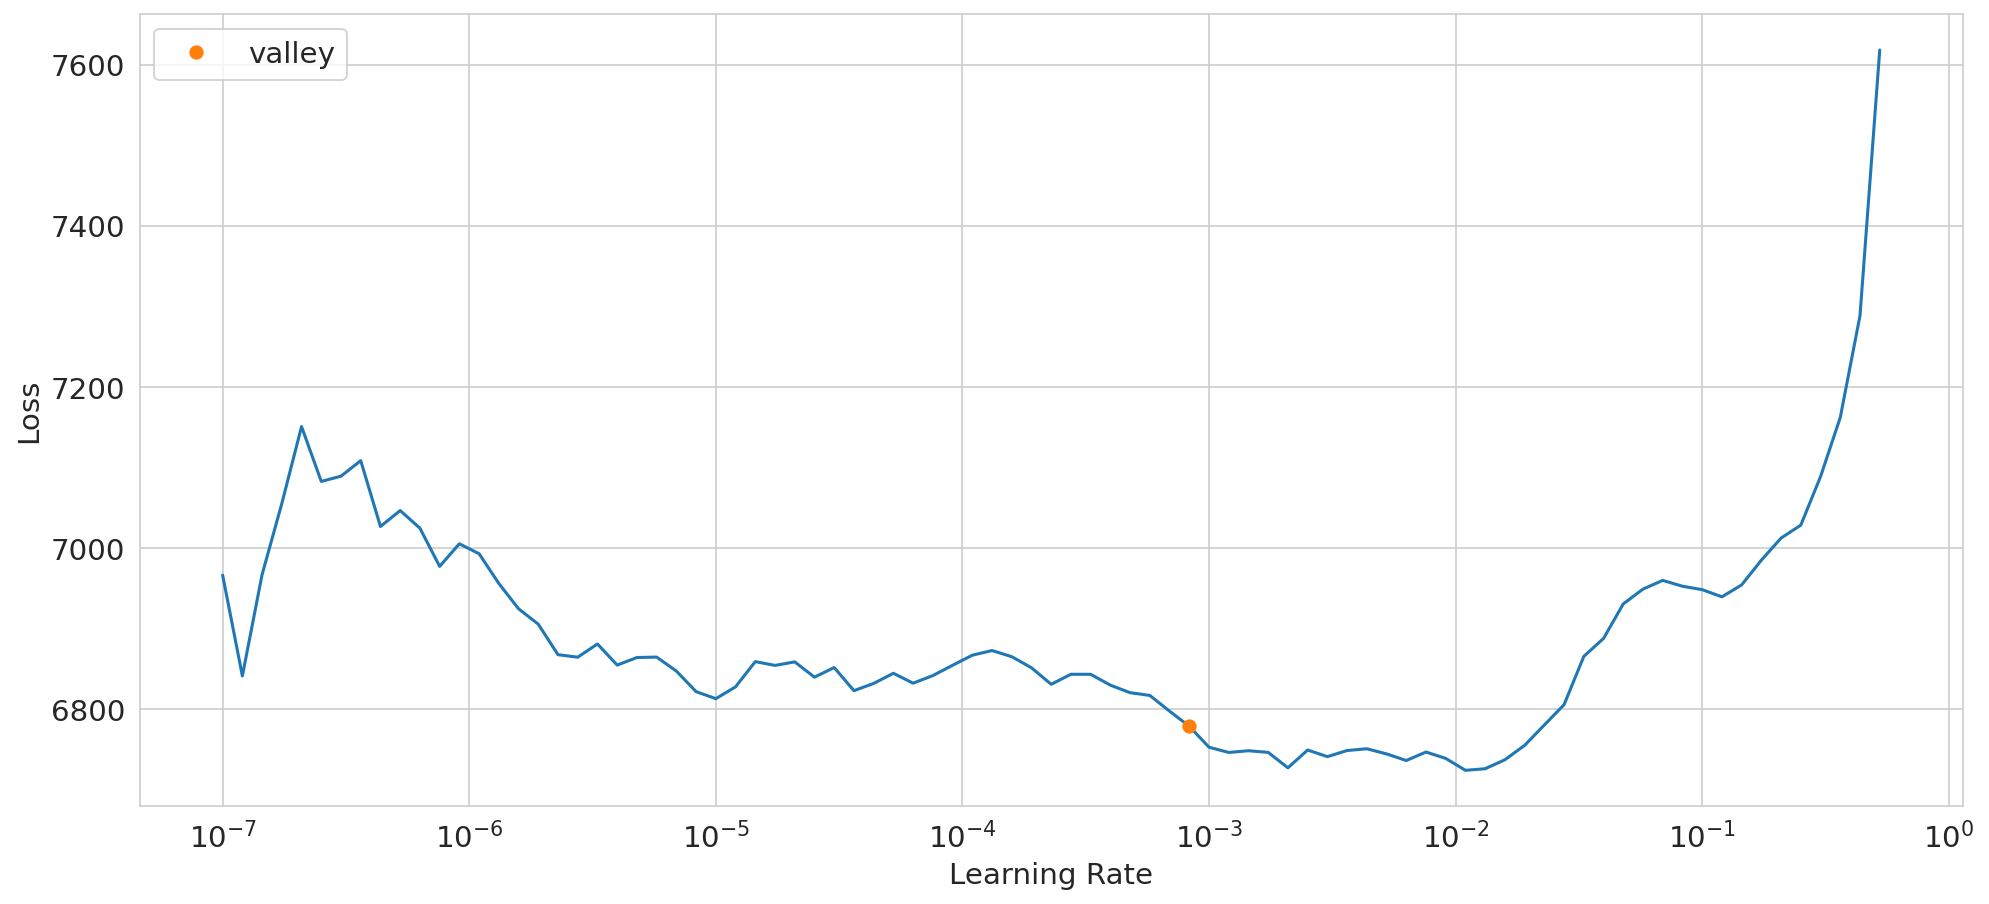

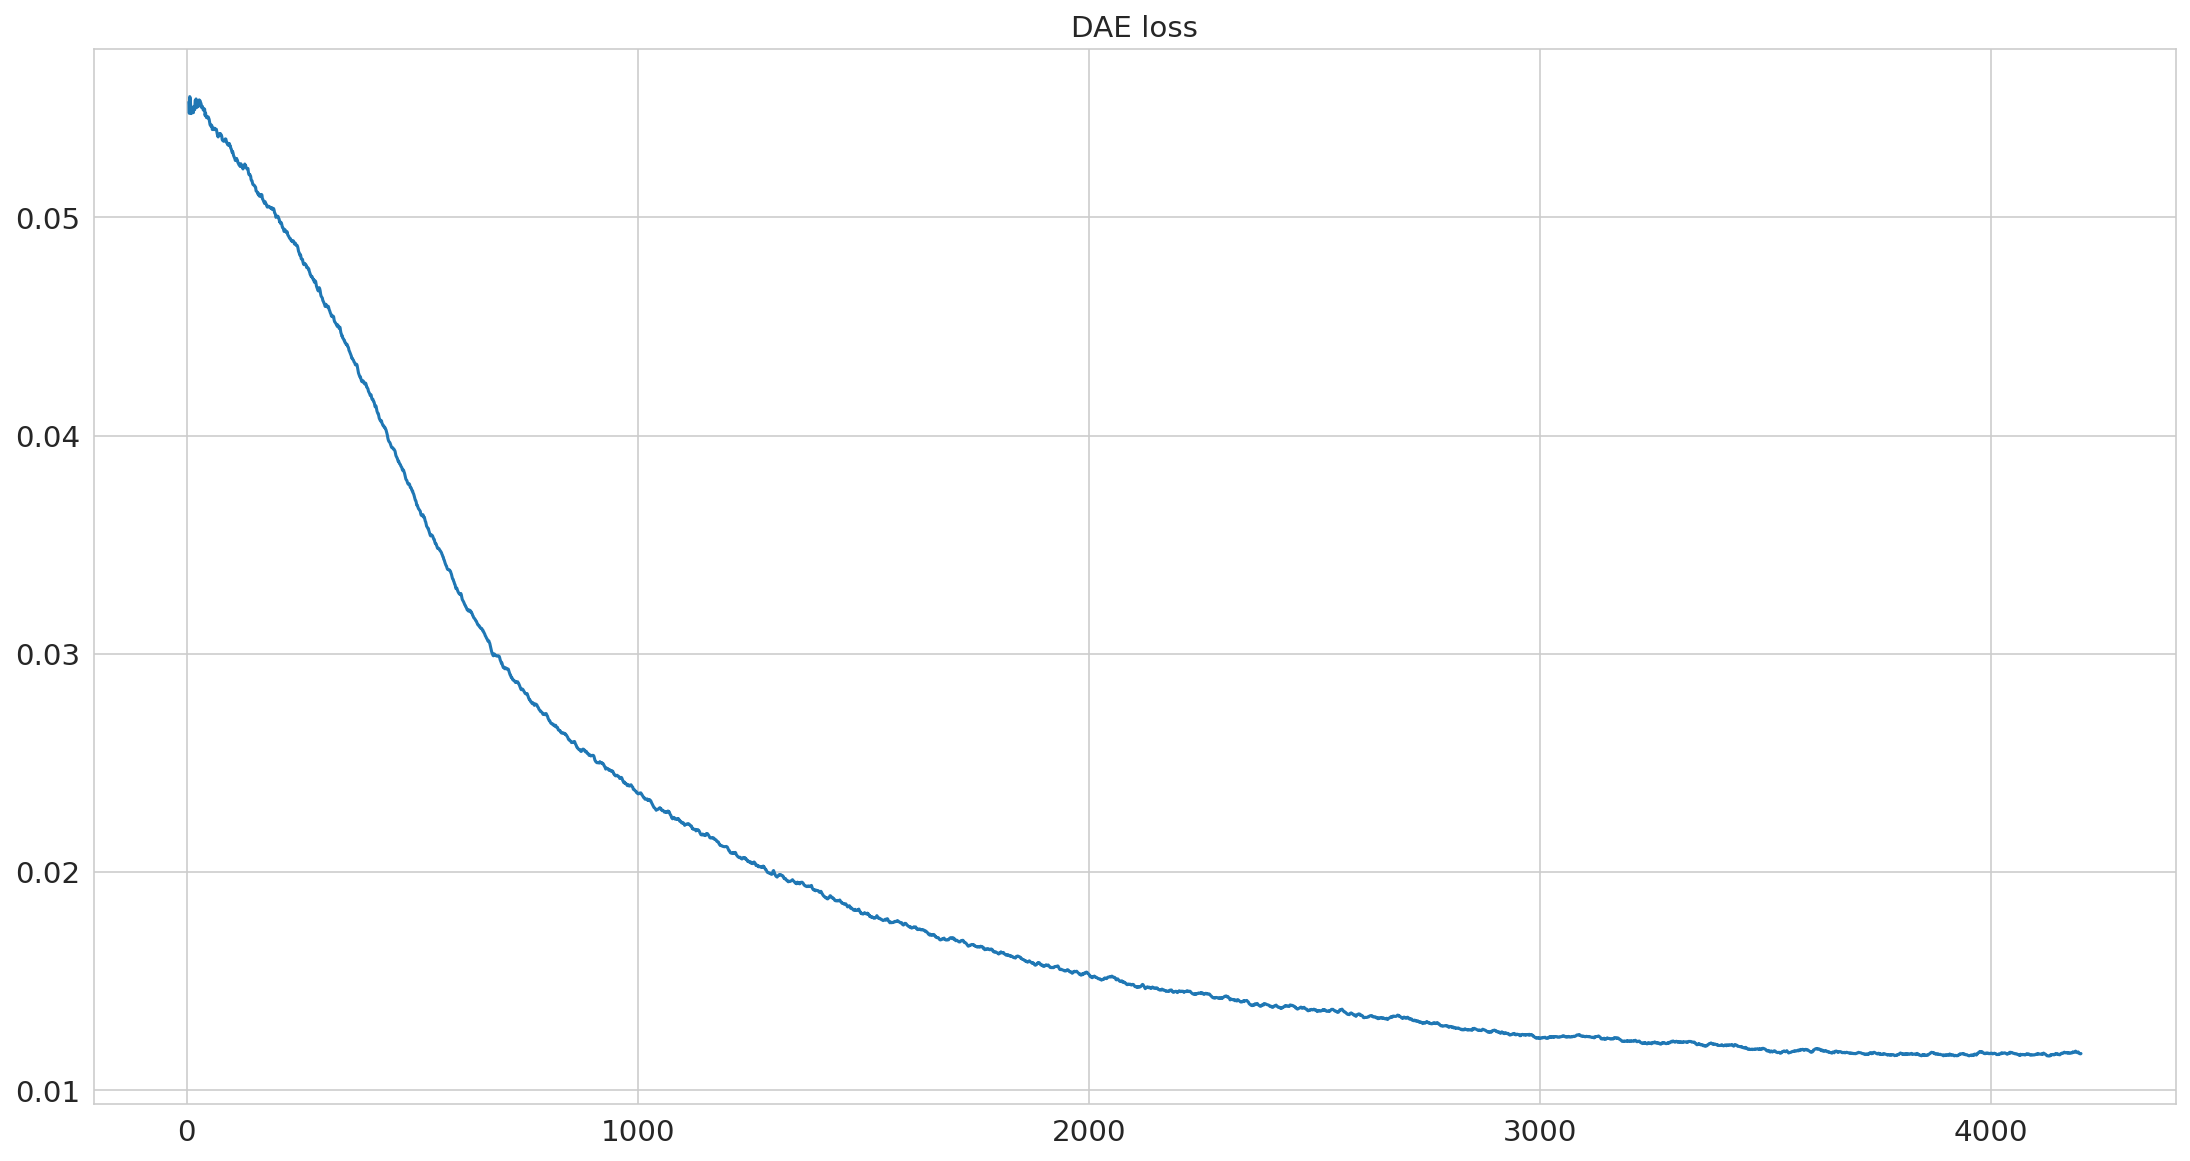

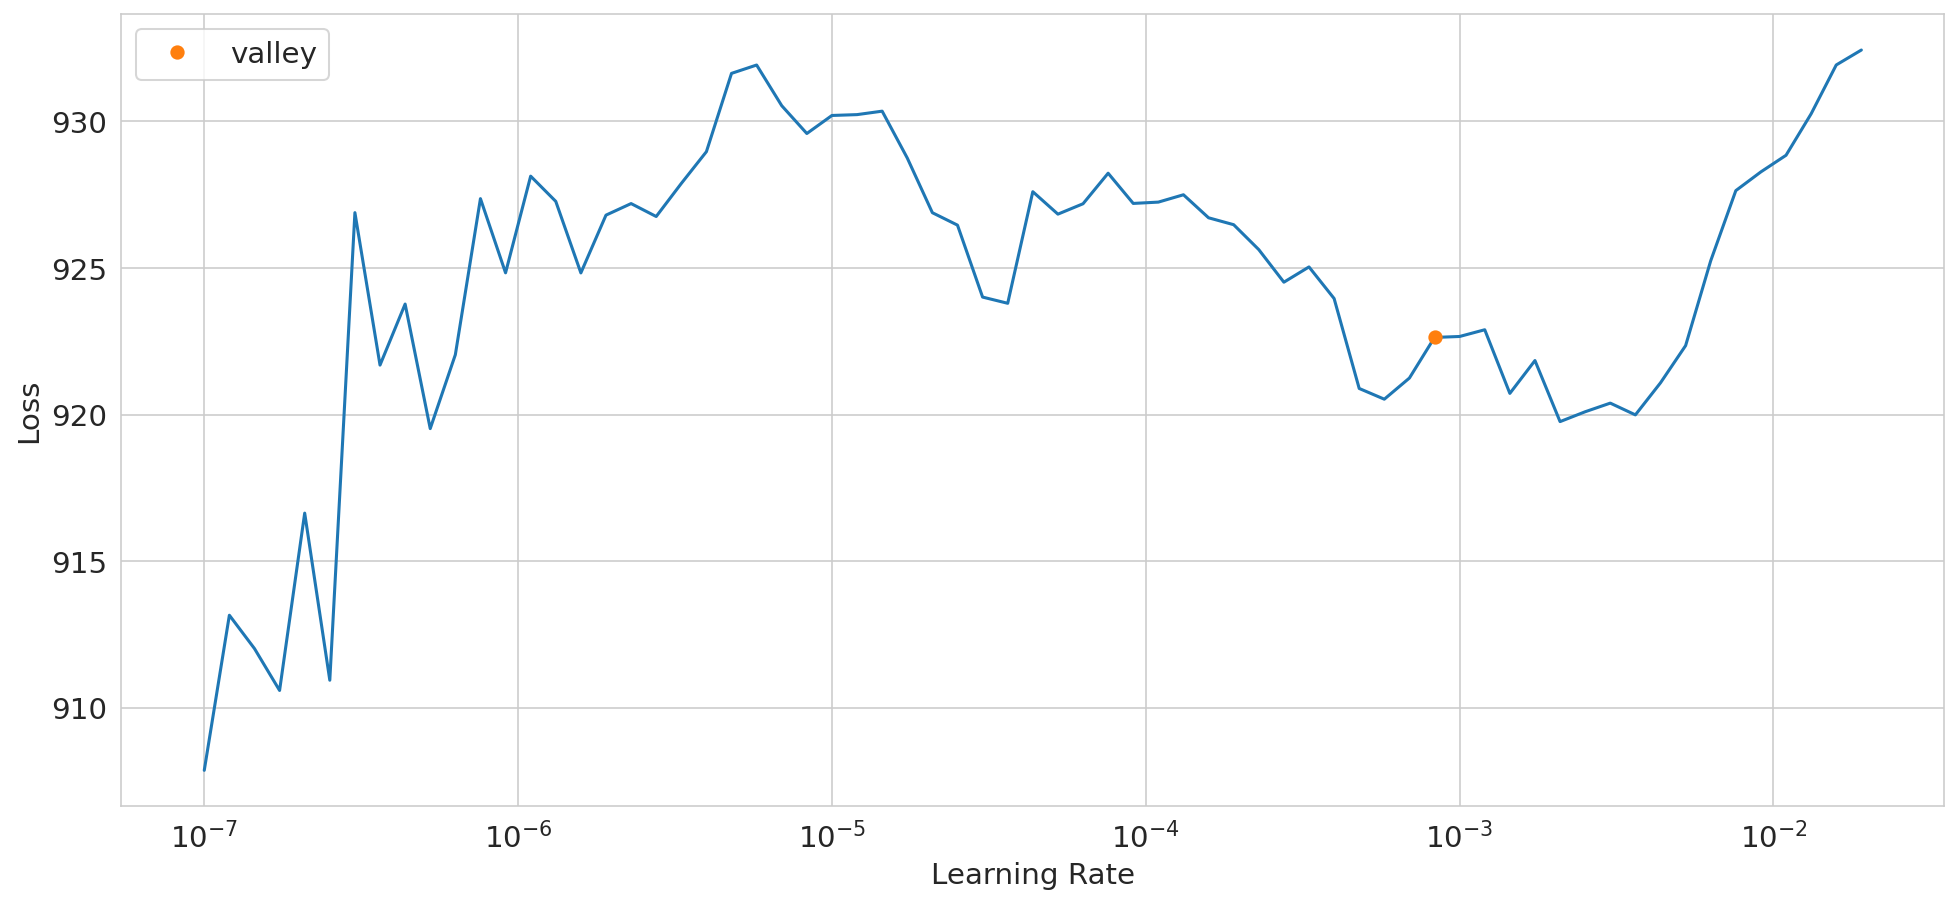

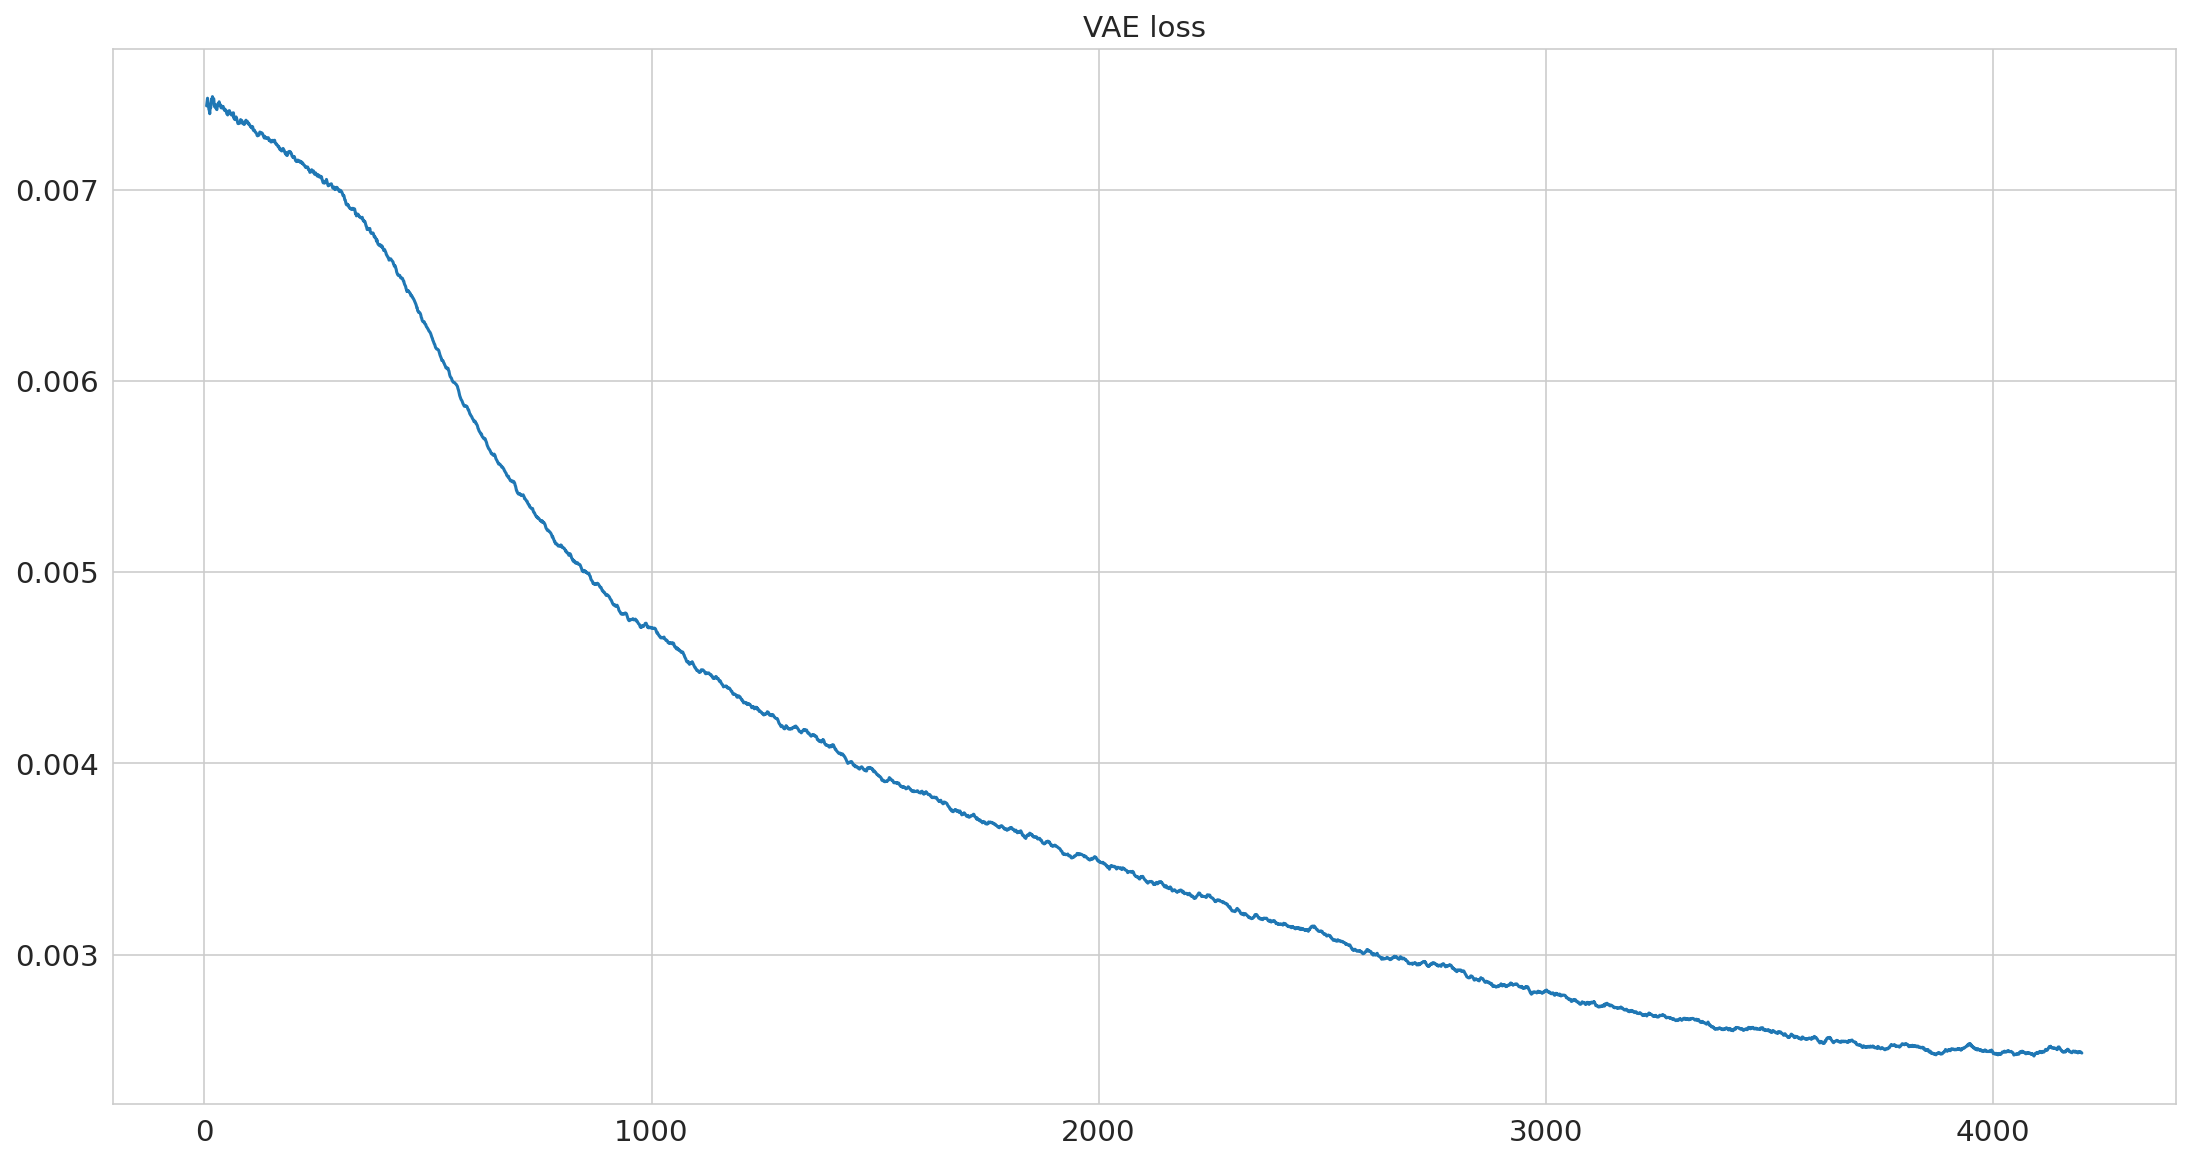

In [18]:
methods = load_impute_methods()
script_results = evaluate_methods(
    dataset=dataset,
    shuffled_datasets=shuffled_datasets,
    methods=methods,
    shuffle_index=0
)
display(script_results)